# Model Building

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_cleaned.csv')

In [3]:
data = data[data.price < 60000]
#data = data[data.age < 15]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8809 entries, 0 to 10954
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      8809 non-null   int64  
 1   carname         8809 non-null   object 
 2   price           8809 non-null   float64
 3   milage          8809 non-null   float64
 4   hubraum         8809 non-null   float64
 5   transmission    8809 non-null   object 
 6   num_seats       8809 non-null   object 
 7   num_doors       8809 non-null   object 
 8   emission_class  8809 non-null   object 
 9   car_type        8809 non-null   object 
 10  num_owners      8809 non-null   object 
 11  age             8809 non-null   float64
 12  power_ps        8809 non-null   float64
 13  power_kw        8809 non-null   float64
 14  Schaden         8809 non-null   object 
 15  Model           8809 non-null   object 
 16  amg             8809 non-null   int64  
 17  mc_laren        8809 non-null   

In [5]:
data.columns

Index(['Unnamed: 0', 'carname', 'price', 'milage', 'hubraum', 'transmission',
       'num_seats', 'num_doors', 'emission_class', 'car_type', 'num_owners',
       'age', 'power_ps', 'power_kw', 'Schaden', 'Model', 'amg', 'mc_laren',
       'blk_series', 'blue_eff', 'g_pow', 'brabus', 'avantgarde', 'elegance',
       'tag_63', 'tag_65', 'tag_55', 'tüv', 'E10', 'biodiesel', 'pflanzenöl',
       'electric', 'fueltype'],
      dtype='object')

In [6]:
data_dummies = data.drop(['carname', 'Unnamed: 0', 'power_kw'], axis=1)

In [7]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8809 entries, 0 to 10954
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           8809 non-null   float64
 1   milage          8809 non-null   float64
 2   hubraum         8809 non-null   float64
 3   transmission    8809 non-null   object 
 4   num_seats       8809 non-null   object 
 5   num_doors       8809 non-null   object 
 6   emission_class  8809 non-null   object 
 7   car_type        8809 non-null   object 
 8   num_owners      8809 non-null   object 
 9   age             8809 non-null   float64
 10  power_ps        8809 non-null   float64
 11  Schaden         8809 non-null   object 
 12  Model           8809 non-null   object 
 13  amg             8809 non-null   int64  
 14  mc_laren        8809 non-null   int64  
 15  blk_series      8809 non-null   int64  
 16  blue_eff        8809 non-null   int64  
 17  g_pow           8809 non-null   

In [8]:
data_dummies = pd.get_dummies(data_dummies, dtype=float)

In [9]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8809 entries, 0 to 10954
Columns: 104 entries, price to fueltype_na
dtypes: float64(88), int64(16)
memory usage: 7.1 MB


In [10]:
data_dummies = data_dummies.astype(float)

In [11]:
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8809 entries, 0 to 10954
Columns: 104 entries, price to fueltype_na
dtypes: float64(104)
memory usage: 7.1 MB


### Split Training & Test Data

In [12]:
data_train, data_test = train_test_split(data_dummies, test_size = 0.25, shuffle=True)

In [13]:
price_max = data_train.price.max()
price_min = data_train.price.min()
print(price_min/price_max)

0.005833430557175953


### Make Features and label data

In [14]:
y_train = data_train[["price"]]  #Labels
X_train = data_train.drop("price", axis=1)  #Features

y_test = data_test[["price"]]  #Labels
X_test = data_test.drop("price", axis=1)  #Features

### Scale features and labels

In [15]:
method = 'MinMax'

if method == 'Standard':
    scalerx = StandardScaler().fit(X_train)
    scalery = StandardScaler().fit(y_train)
    
elif method == 'MinMax':
    scalerx = MinMaxScaler().fit(X_train)
    scalery = MinMaxScaler().fit(y_train)
    
elif method == 'Robust':
    scalerx = RobustScaler().fit(X_train)
    scalery = RobustScaler().fit(y_train)

In [16]:
X_train = pd.DataFrame(scalerx.transform(X_train), columns=X_train.columns)
y_train = pd.DataFrame(scalery.transform(y_train), columns=y_train.columns)
y_train = y_train.T.squeeze()

X_test = pd.DataFrame(scalerx.transform(X_test), columns=X_test.columns)
y_test = pd.DataFrame(scalery.transform(y_test), columns=y_test.columns)
y_test = y_test.T.squeeze()

In [17]:
y_train.max()

0.9999999999999999

In [18]:
y_train.min()

0.0

### Automating Feature Selection and Regression Model Building

In [19]:
print('Dropping features with p-value P(t) > 0.05: \n')
cols = list(X_train.columns)
pmax = 1
i = 1
while (len(cols) > 0):
    p = []
    X_1 = X_train
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if pmax > 0.05:
        cols.remove(feature_with_p_max)
        X_train = X_train.drop(feature_with_p_max, axis=1)
        X_test = X_test.drop(feature_with_p_max, axis=1)
        print(str(i) + '. Dropped', feature_with_p_max, 'with p-value', pmax)
        i += 1
    else:
        break
selected_features = cols
print('\n\nSelected features: \n\n', selected_features)

Dropping features with p-value P(t) > 0.05: 

1. Dropped num_owners_2 with p-value 0.952815189822287
2. Dropped tag_55 with p-value 0.9361401270415466
3. Dropped biodiesel with p-value 0.8167436754929669
4. Dropped emission_class_Euro6c with p-value 0.79102696537542
5. Dropped emission_class_Euro6d-TEMP with p-value 0.8941852018968756
6. Dropped num_owners_6 with p-value 0.787237076164825
7. Dropped mc_laren with p-value 0.7180592990006144
8. Dropped Model_OTHER with p-value 0.699948535247009
9. Dropped Model_SL with p-value 0.6021672630091774
10. Dropped avantgarde with p-value 0.6065280667142122
11. Dropped Model_GL with p-value 0.600417801294411
12. Dropped g_pow with p-value 0.9040981750760909
13. Dropped Model_GT with p-value 0.5961703614874165
14. Dropped Model_Sprinter with p-value 0.6238314462128529
15. Dropped num_owners_4 with p-value 0.5936151139638532
16. Dropped num_doors_na with p-value 0.5817466115527734
17. Dropped elegance with p-value 0.574027034831117
18. Dropped fue

In [20]:
X_train.shape

(6606, 62)

In [21]:
type(X_train)

pandas.core.frame.DataFrame

In [22]:
X_test.shape

(2203, 62)

In [23]:
type(X_test)

pandas.core.frame.DataFrame

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1154.
Date:                Fri, 15 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:57:20   Log-Likelihood:                 6618.4
No. Observations:                6606   AIC:                        -1.311e+04
Df Residuals:                    6545   BIC:                        -1.270e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3306      0.009     36.388      0.000       0.313       0.348
milage                    -0.5831      0.016    -37.560      0.000      -0.614      -0.553
hubraum                   -0.1207      0.019     -6.237      0.000      -0.159      -0.083
age                       -0.5155      0.012    -43.866      0.000      -0.539      -0.492
power_ps                   0.6224      0.017     35.704      0.000       0.588       0.657
amg                        0.0561      0.003     17.420      0.000       0.050       0.062
blue_eff                  -0.0316      0.005     -6.931      0.000      -0.041      -0.023
tag_63                     0.0437      0.009      5.128      0.000       0.027       0.060
tag_65                     0.1085      0.029      3.777      0.000       0.052       0.165
tüv                        0.0182      0.006      3.116      0.002       0.007       0.030
transmission_Automatik     0.0203      0.003      6.329      0.000       0.014       0.027
num_seats_2               -0.0312      0.009     -3.332      0.001      -0.049      -0.013
num_seats_3               -0.0408      0.010     -4.000      0.000      -0.061      -0.021
num_seats_6                0.0324      0.011      3.024      0.003       0.011       0.053
num_seats_7                0.0545      0.010      5.610      0.000       0.035       0.074
num_seats_8                0.0434      0.010      4.180      0.000       0.023       0.064
num_seats_na               0.0423      0.007      5.744      0.000       0.028       0.057
num_doors_2/3              0.0948      0.011      8.745      0.000       0.074       0.116
num_doors_4/5              0.0796      0.009      8.710      0.000       0.062       0.098
emission_class_Euro1       0.4967      0.052      9.465      0.000       0.394       0.600
emission_class_Euro2       0.0710      0.019      3.718      0.000       0.034       0.108
emission_class_Euro4      -0.0938      0.006    -16.388      0.000      -0.105      -0.083
emission_class_Euro5      -0.1063      0.005    -20.240      0.000      -0.117      -0.096
emission_class_Euro6      -0.0518      0.004    -14.461      0.000      -0.059      -0.045
emission_class_na         -0.0175      0.006     -3.081      0.002      -0.029      -0.006
car_type_andere            0.0321      0.005      6.311      0.000       0.022       0.042
car_type_cabrio            0.0942      0.008     12.467      0.000       0.079       0.109
car_type_kleinwagen        0.0502      0.007      7.506      0.000       0.037       0.063
car_type_kombi             0.0222      0.004      6.076      0.000       0.015       0.029
car_type_limousine         0.0138      0.003      4.255      0.000       0.007       0.020
car_type_sport             0.0528      0.005     11.459      0.000       0.044  

In [25]:
def plot(y_pred, y_true, savename, color):
    fig, ax = plt.subplots(figsize=(6, 5)) 
    sns.scatterplot(y=y_true, x=y_pred, color=color, s=5)
    xx = np.linspace(min(y_pred), max(y_pred), num=50)
    plt.plot(xx, xx, color='k', linewidth=2)
    plt.title('Prediction on ' + savename + ' Dataset')
    plt.xlabel('Predicted Price')
    plt.ylabel('True Price')
    plt.tight_layout()
    #ax.xaxis.set_major_formatter(ticker.EngFormatter())
    #ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.grid(True)
    plt.show()
    fig.savefig('Plots/'+savename+'.png', dpi=300)

In [26]:
try:
    test_pred = model.predict(sm.add_constant(X_test))
except:
    test_pred = model.predict(sm.add_constant(X_test, has_constant='add'))

try:
    train_pred = model.predict(sm.add_constant(X_train))
except:
    train_pred = model.predict(sm.add_constant(X_train, has_constant='add'))

In [27]:
def rescale_label(label):
    Y = np.array([label])  # make 2D-Array
    return list(scalery.inverse_transform(Y)[0])

### Performance on unseen Test Dataset

In [28]:
sm.tools.eval_measures.meanabs(y_test, test_pred)

0.06686981149182128

In [29]:
sm.tools.eval_measures.meanabs(rescale_label(y_test), rescale_label(test_pred))

3988.717385675648

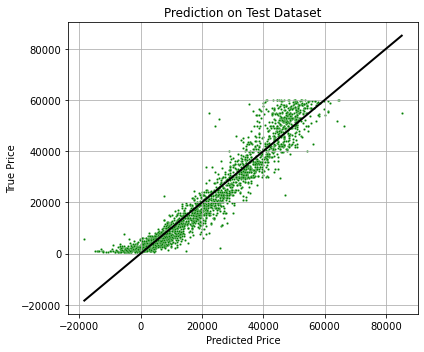

In [30]:
plot(rescale_label(test_pred), rescale_label(y_test), 'Test', 'g')

In [31]:
#plot(test_pred[0], y_test[0], 'Test')

In [32]:
# ROBUST 0.16 8643
# STANDARD 0.23  8478
# MINMAX 0.05  8426

### Performance on seen Training Dataset

In [33]:
sm.tools.eval_measures.meanabs(rescale_label(y_train), rescale_label(train_pred))

3958.343600314118

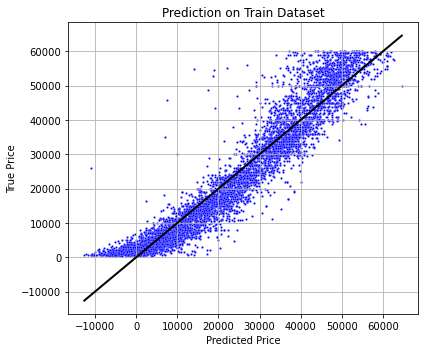

In [34]:
plot(rescale_label(train_pred), rescale_label(y_train), 'Train', 'b')

### Problem of negative Prices

- modelling log-price; this is a common strategy with price-like variables in economics
- using generalized linear models (GLMs). A gamma-model with a log-link would be quite similar to modelling log-price, but the model would be for the expected price rather than expected log-price. This may have some advantages. If you need the relationship with the predictors to be linear in actual price, this can be done (identity link), but a log link for this sort of data would be more common.

## Regression with Neural Network 

In [35]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal

In [36]:
class Network(nn.Module):
    def __init__(self, n_input, lr):
        super(Network, self).__init__()
        
        fc1 = 200
        fc2 = 100

        self.fc1 = nn.Linear(n_input, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.out = nn.Linear(fc2, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr, eps=1e-5)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, inputs):
        x = F.relu(self.fc1(inputs))
        x = F.relu(self.fc2(x))
        out = F.relu(self.out(x))
        
        return out

In [37]:
X_train = np.array(X_train)
X_train = T.tensor(X_train, dtype=T.float32)
y_train = T.tensor(y_train, dtype=T.float32)

X_test = np.array(X_test)
X_test = T.tensor(X_test, dtype=T.float32)
y_test = T.tensor(y_test, dtype=T.float32)

input_nodes = X_train.shape[1]
input_nodes

62

In [38]:
model = Network(input_nodes, 0.005)
loss_func = nn.MSELoss()
mae_func = nn.L1Loss()

In [39]:
def calc_MAE(preds, true):
    preds = np.array(preds)
    true = np.array(true)
    return np.abs(preds - true).sum() / preds.shape[0]

In [40]:
loss_train = []
loss_test = []
mae_train = []
mae_test = []

for epochs in range(200):
    
    prediction = T.squeeze(model(X_train))
    loss = loss_func(prediction, y_train)
    mae_tr = mae_func(prediction, y_train).detach()
    
    prediction_test = T.squeeze(model(X_test)).detach()
    test_loss = loss_func(prediction_test, y_test).detach()
    mae_te = mae_func(prediction_test, y_test).detach()
    
    loss_train.append(loss.detach().item())
    loss_test.append(test_loss.item())
    mae_test.append(mae_te.item())
    mae_train.append(mae_tr.item())
    
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    

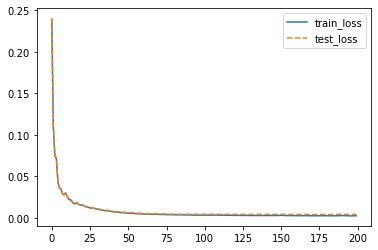

In [41]:
plt.figure()
plt.plot(loss_train, label='train_loss')
plt.plot(loss_test, '--', label='test_loss')
plt.legend()
plt.show()

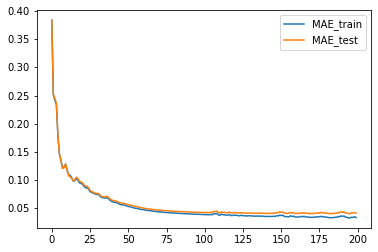

In [42]:
plt.figure()
plt.plot(mae_train, label='MAE_train')
plt.plot(mae_test, label='MAE_test')
plt.legend()
plt.show()

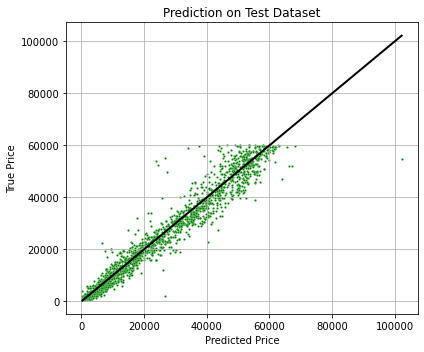

2457.6109850204266


In [43]:
test_pred = T.squeeze(model(X_test).detach())
plot(rescale_label(test_pred.numpy()), rescale_label(y_test.numpy()), 'Test', 'green')
MAE = calc_MAE(rescale_label(test_pred.numpy()), rescale_label(y_test.numpy()))
print(MAE)

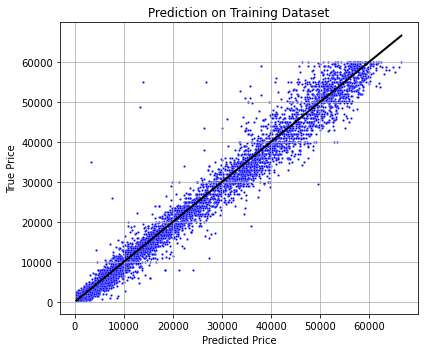

1987.3327278231911


In [44]:
train_pred = T.squeeze(model(X_train).detach())
plot(rescale_label(train_pred.numpy()), rescale_label(y_train.numpy()), 'Training', 'blue')
MAE = calc_MAE(rescale_label(train_pred.numpy()), rescale_label(y_train.numpy()))
print(MAE)